In [63]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data)


json_file_path = r'C:\Users\mohal\Downloads\districting_data_extracted\districting-data-2020-county\ID_county.json'
graph = read_graph_from_json(json_file_path)


print(graph.nodes)  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [79]:

for node, data in G.nodes(data=True):
    county_name = node  
    population = data.get('TOTPOP', 'N/A')  
    latitude = data.get('C_Y', 'N/A')  
    longitude = data.get('C_X', 'N/A')  
    
    
    print(f"Node {node} is {county_name}, which has population {population} and is centered at ({longitude}, {latitude})")



Node 0 is 0, which has population 7974 and is centered at (-113.8870422, +44.9285059)
Node 1 is 1, which has population 494967 and is centered at (-116.2443760, +43.4514767)
Node 2 is 2, which has population 24655 and is centered at (-113.6263276, +42.2823130)
Node 3 is 3, which has population 4564 and is centered at (-112.5204486, +42.1838954)
Node 4 is 4, which has population 8734 and is centered at (-115.6535003, +46.6725700)
Node 5 is 5, which has population 7610 and is centered at (-115.7151105, +43.9872749)
Node 6 is 6, which has population 25386 and is centered at (-116.7502379, +44.0024300)
Node 7 is 7, which has population 13169 and is centered at (-115.8850916, +47.3476935)
Node 8 is 8, which has population 13388 and is centered at (-111.4844290, +44.2180909)
Node 9 is 9, which has population 3533 and is centered at (-116.4237600, +46.2363277)
Node 10 is 10, which has population 87018 and is centered at (-112.2289819, +42.6929211)
Node 11 is 11, which has population 90046 and

In [80]:
from geopy.distance import geodesic


dist = { (i, j): 0 for i in G.nodes for j in G.nodes }


for i in G.nodes:
    for j in G.nodes:
        
        loc_i = (G.nodes[i]['C_Y'], G.nodes[i]['C_X'])
        loc_j = (G.nodes[j]['C_Y'], G.nodes[j]['C_X'])  
        
        
        dist[i, j] = geodesic(loc_i, loc_j).miles  


print(f"Distance between node 0 and node 1: {dist[0, 1]} miles")


Distance between node 0 and node 1: 155.2759354316712 miles


In [81]:
import math


deviation = 0.01


k = 2


total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)


L = math.ceil((1 - deviation / 2) * total_population / k)
U = math.floor((1 + deviation / 2) * total_population / k)


print("Using L =", L, "and U =", U, "and k =", k)


Using L = 914956 and U = 924150 and k = 2


In [82]:
import gurobipy as gp
from gurobipy import GRB

 
m = gp.Model()


x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

In [83]:

m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [84]:

m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )


m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )


m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )


m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [85]:

import networkx as nx
DG = nx.DiGraph(G)


f = m.addVars( DG.edges, G.nodes ) 


m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )


M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )


m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [86]:

m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0

Optimize a model with 5897 rows, 10912 columns and 39940 nonzeros
Model fingerprint: 0xf08c3649
Variable types: 8976 continuous, 1936 integer (1936 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+05]
  Objective range  [9e+05, 7e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 174 rows and 291 columns
Presolve time: 0.13s
Presolved: 5723 rows, 10621 columns, 39230 nonzeros
Variable types: 8685 continuous, 1936 integer (1936 binary)

Root relaxation: objective 2.606803e+10, 1062 iterations, 0.09 seconds (0.07 work units)

In [87]:

print(m.objVal)



centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]


for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

28154419273.267452
District 0 has population 921109 and contains counties ['Lemhi', 'Cassia', 'Oneida', 'Boise', 'Fremont', 'Bannock', 'Twin Falls', 'Owyhee', 'Gooding', 'Caribou', 'Bear Lake', 'Lincoln', 'Camas', 'Canyon', 'Jefferson', 'Franklin', 'Madison', 'Clark', 'Jerome', 'Custer', 'Bonneville', 'Teton', 'Power', 'Blaine', 'Elmore', 'Butte', 'Valley', 'Minidoka', 'Bingham']

District 1 has population 917997 and contains counties ['Ada', 'Clearwater', 'Payette', 'Shoshone', 'Lewis', 'Washington', 'Latah', 'Boundary', 'Kootenai', 'Gem', 'Idaho', 'Benewah', 'Nez Perce', 'Adams', 'Bonner']



In [88]:
import geopandas as gpd


filepath = r'C:\Users\mohal\Downloads\districting_data_extracted\districting-data-2020-county\\'  
filename = 'ID_county.shp'  


df = gpd.read_file(filepath + filename)


print(df.head())

  STATEFP20 COUNTYFP20 COUNTYNS20 GEOID20      NAME20         NAMELSAD20  \
0        16        059   00399754   16059       Lemhi       Lemhi County   
1        16        001   00395066   16001         Ada         Ada County   
2        16        031   00395698   16031      Cassia      Cassia County   
3        16        071   00399759   16071      Oneida      Oneida County   
4        16        035   00395697   16035  Clearwater  Clearwater County   

  LSAD20 CLASSFP20 MTFCC20 CSAFP20 CBSAFP20 METDIVFP20 FUNCSTAT20  \
0     06        H1   G4020    None     None       None          A   
1     06        H1   G4020     147    14260       None          A   
2     06        H1   G4020    None    15420       None          A   
3     06        H1   G4020    None     None       None          A   
4     06        H1   G4020    None     None       None          A   

       ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0  11819914566  14105634  +44.9285059  -113.8870422   
1   2724704673  22

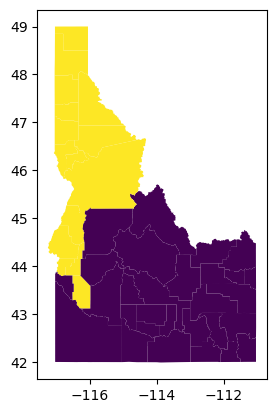

In [74]:

assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j


node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }


for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    
    i = node_with_this_geoid[geoid]
    
    
    
    assignment[u] = labeling[i]
    

df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()